# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Моисеев".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

***Задача 1. Сходимость kmeans.***

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Решение***

Минимизируем $L(C) = \sum_{k=1}^K\sum_{i\in C_k} (x_i - \mu_k)^2 \rightarrow \min\limits_C$.

Пусть случайным образом выбраны начальные центроиды и вычислен шаг $E$.

$E \rightarrow M$. Рассмотрим каждую из сумм $\sum_{i\in C_k} (x_i - \mu_k)^2$. Как функция от $\mu_k$ она достигает минимума при $\mu_k = \dfrac{1}{|C_k|}\sum_{i\in C_k} x_i$. Именно такая коррекция и производится на шаге $M$. Значит, после него $L(C)$ не возрастает.

$M \rightarrow E$. Для каждого $x_i$ его центроидой "назначается" ближайшая к нему $\mu_k^{new}$, то есть, $(x_i - \mu_K^{old}) \geq (x_i - \mu_K^{new})$. После шага $L(C)$ не возрастает.

Каждое разбиение после применения $M$-шага однозначно определяет положение центроид. Существует $k^N$ возможных разбиений точек на кластеры, значит, после $k^N$ шагов невозрастания точно найдётся стационарная точка и процесс сойдётся. Из построения алгоритма следует, что при первом же достижении $L(C_{old}) = L(C_{new})$ процесс никогда не выйдет из этого состояния.

***Задача 2. Сходимость EM.***

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?

***Решение***

На M-шаге алгоритма правдоподобие максимизируется; в результате E-шага оно также не убывает. Таким образом, при ограниченности правдоподобия алгоритм сойдётся.

***Задача 3. Формулы Ланса-Вильямса.***

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Решение***

Допустим, что $d_{\min}(U \cup V, S)$ достигается на $\hat{\mathbf{x}} \in U$, $\hat{\mathbf{x}}' \in S$. Тогда $d_{\min}(U, S) \leq d_{\min}(V, S)$, поскольку в противном случае существовала бы пара $\hat{\mathbf{x}}_1 \in V$, $\hat{\mathbf{x}}'_1 \in S$, для которых $\|\hat{\mathbf{x}}_1 - \hat{\mathbf{x}}'_1 \| < \|\hat{\mathbf{x}} - \hat{\mathbf{x}}'\|$, что противоречит нашему изначальному предположению. Тогда правая часть формулы принимает вид $d_{\min}(U, S)$, который также равен $\|\hat{\mathbf{x}} - \hat{\mathbf{x}}'\|$. Аналогично − если $d_{\min}(U \cup V, S)$ достигается на некоторых $\hat{\mathbf{x}} \in V$, $\hat{\mathbf{x}}' \in S$.

Допустим, что $d_{\max}(U \cup V, S)$ достигается на $\hat{\mathbf{x}} \in U$, $\hat{\mathbf{x}}' \in S$. Тогда $d_{\max}(U, S) \geq d_{\max}(V, S)$, поскольку в противном случае существовала бы пара $\hat{\mathbf{x}}_1 \in V$, $\hat{\mathbf{x}}'_1 \in S$, для которых $\|\hat{\mathbf{x}}_1 - \hat{\mathbf{x}}'_1 \| > \|\hat{\mathbf{x}} - \hat{\mathbf{x}}'\|$, что противоречит нашему изначальному предположению. Тогда правая часть формулы принимает вид $d_{\max}(U, S)$, который также равен $\|\hat{\mathbf{x}} - \hat{\mathbf{x}}'\|$. Аналогично − если $d_{\max}(U \cup V, S)$ достигается на некоторых $\hat{\mathbf{x}} \in V$, $\hat{\mathbf{x}}' \in S$.

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [15]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import pairwise_distances

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """

    def __init__(self, linkage_type="single-linkage", n_clusters=2):
        self.linkage_type = linkage_type
        self.n_clusters = n_clusters


    def _distance(self, dist1, dist2, size1, size2):
        if self.linkage_type == "single-linkage":
            return (dist1 + dist2 - abs(dist1 - dist2)) / 2.0
        elif self.linkage_type == "complete-linkage":
            return (dist1 + dist2 + abs(dist1 - dist2)) / 2.0
        elif self.linkage_type == "average-linkage":
            return (size1 * dist1 + size2 * dist2) / (size1 + size2)
        else:
            raise AttributeError("Linkage type")


    def linkage_to(self, x, step):
        n = x.shape[0]
        dist = np.empty(shape=(n + step, n + step))
        dist[:n, :n] = pairwise_distances(x)

        self.Z = np.empty(shape=(step, 4))

        clusters = set(list(range(0, n)))

        def size(ind):
            if ind < n:
                return 1
            else:
                return self.Z[ind - n, 3]

        for c_ind in range(n, n + step):
            #Search the closest clusters by analysing upper triangle 
            #of current clusters distance submatrix
            cut_cl = list(clusters)
            len_tr = len(cut_cl)
            cut_tr = np.triu_indices(len_tr, k=1)
            min_rav_1 = dist[:, cut_cl][cut_cl, :][cut_tr].argmin()
            min_rav_2 = np.ravel_multi_index(cut_tr, (len_tr, len_tr))[min_rav_1]
            min_sub = np.unravel_index(min_rav_2, (len_tr, len_tr))
            to_aggl = [cut_cl[min_sub[0]], cut_cl[min_sub[1]]]
                            
            self.Z[c_ind - n, 0] = to_aggl[0]
            self.Z[c_ind - n, 1] = to_aggl[1]
            self.Z[c_ind - n, 2] = dist[to_aggl[0], to_aggl[1]]
            self.Z[c_ind - n, 3] = size(to_aggl[0]) + size(to_aggl[1])

            clusters.remove(to_aggl[0])
            clusters.remove(to_aggl[1])

            dist[cut_cl, c_ind] = self._distance(dist[cut_cl, to_aggl[0]], 
                                                 dist[cut_cl, to_aggl[1]],
                                                  size(to_aggl[0]), size(to_aggl[1]))
            dist[c_ind, cut_cl] = dist[cut_cl, c_ind]

            clusters.add(c_ind)

        self.clusters = clusters
        return self.Z
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        n = x.shape[0]
        self.linkage_to(x, n - self.n_clusters)

        return self


    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        n = x.shape[0]
        self.labels = np.empty(n)

        def set_label(label, ind):
            if ind >= n:
                set_label(label, int(self.Z[ind - n, 0]))
                set_label(label, int(self.Z[ind - n, 1]))
            else:
                self.labels[int(ind)] = label

        label_num = 0
        for clust in self.clusters:
            set_label(label_num, clust)
            label_num += 1

        return self.labels.astype(int)
    
    def fit_predict(self, x):
        self.fit(x)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

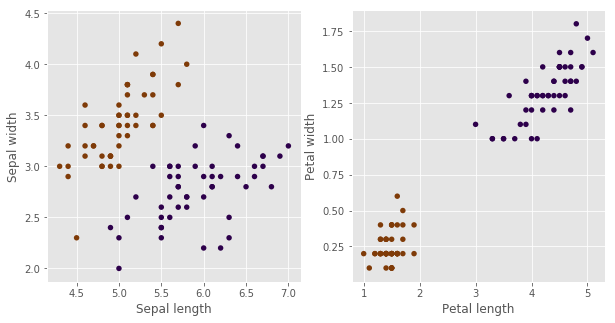

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [5]:
pred_iris = Clustering().fit_predict(x_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


In [121]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)

print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.45745396614074707. AGGL score 1.0. AGGL time 0.02996540069580078


In [122]:
my_aggl = Clustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = my_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("My AGGL score {}. My AGGL time {}".format(aggl_score, aggl_diff))

My AGGL score 1.0. My AGGL time 0.026642799377441406


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [2]:
df = pd.read_excel("WDIEXCEL.xlsx")

In [3]:
df.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.243897,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.432827,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.402277,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN
5,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,95.690832,95.126062,95.837901,95.985879,96.006040,96.386068,96.411432,96.574021,96.704393,NaN
6,Arab World,ARB,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22.260538,NaN,NaN,30.277130,NaN,NaN,37.165211
7,Arab World,ARB,Account ownership at a financial institution o...,FX.OWN.TOTL.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.775815,NaN,NaN,22.079350,NaN,NaN,25.635403
8,Arab World,ARB,Account ownership at a financial institution o...,FX.OWN.TOTL.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.377668,NaN,NaN,37.790764,NaN,NaN,48.328518
9,Arab World,ARB,Account ownership at a financial institution o...,FX.OWN.TOTL.OL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25.741285,NaN,NaN,34.216583,NaN,NaN,42.542046


In [4]:
countries = df['Country Name'].unique()[47:]

In [5]:
df['Indicator Name'].unique()

array(['2005 PPP conversion factor, GDP (LCU per international $)',
       '2005 PPP conversion factor, private consumption (LCU per international $)',
       'Access to clean fuels and technologies for cooking  (% of population)',
       ...,
       'Women who were first married by age 15 (% of women ages 20-24)',
       'Women who were first married by age 18 (% of women ages 20-24)',
       "Women's share of population ages 15+ living with HIV (%)"],
      dtype=object)

In [6]:
X = np.empty((len(countries), df['Country Name'].value_counts()[0]))

In [7]:
Year = '1995'

for ind in range(len(countries)):
    X[ind] = df[df['Country Name'] == countries[ind]][Year].values.T

In [8]:
mean = np.nanmean(X, axis=0)

inds = np.where(np.isnan(X))
X[inds] = np.take(mean, inds[1])

X = np.nan_to_num(X)

/home/george/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [12]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

In [34]:
clf = Clustering(linkage_type='average-linkage')
link = clf.linkage_to(X, X.shape[0] - 1)

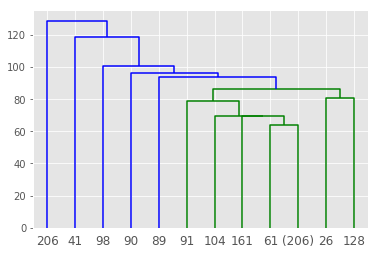

In [35]:
from scipy.cluster.hierarchy import dendrogram, cophenet

dendrogram(link, p=12, truncate_mode='lastp')
plt.show()

In [36]:
clf = Clustering(n_clusters=6)
ans = clf.fit_predict(X)

In [47]:
countries[ans == 0]

array(['China'], dtype=object)

In [38]:
from sklearn.decomposition import PCA

red = PCA(n_components=10)

In [39]:
X = red.fit_transform(X)

clf = Clustering(linkage_type='average-linkage')
link = clf.linkage_to(X, X.shape[0] - 1)

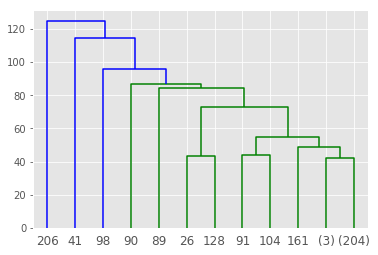

In [40]:
dendrogram(link, p=12, truncate_mode='lastp')
plt.show()

Я не представляю, что с этим делать. Ручной выбор признаков из списка в 1600 элементов не выглядит выполнимой задачей, не менее непонятно, как какой-либо из автоматических алгоритмов понижения размерности поможет мне выполнить задание, связанное с анализом определяющих близость стран признаков (и поможет ли получить адекватный результат вообще).

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

Поиски выбросов; формирования категорий клиентов, продуктов, текстов, данных и прочее упорядочивание имеющейся информации.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

KMeans прост для реализации и понятен интуитивно, но проигрывает в случае несферических кластеров. Даже для примитивных задач может выдасть неудовлетворительный результат, попав в стационарную точку. 

DBScan проявляет себя на кластерах самых диких форм и не требует задания количества кластеров. Сложность проявляется в необходимости определения радиуса окрестности точки для каждых конкретных данных.

Аггломеративная кластеризация проигрывает предыдущим двум по скорости и болезненно реагирует на выбросы; в то же время она не привязана к форме кластера и даёт очень наглядный результат (и за один прогон позволяет получить полное дерево, исходя из которого можно почти без лишних рассчётов выбрать любое число кластеров).

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

Если мы будем, как здесь, отталкиваться от нормального распределения, то, очевидно, стоит избегать применения алгоритма к тем данным, которые его явно не имеют. То же верно и для моделирования на других распределниях. Опять же, следует не забывать про необходимость ограничения правдоподобия.

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

Да, страдают. Побороть не знаю как.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

Можно оттолкнуться от частотных характеристик встречаемости тех или иных слов и, измеряя расстояние между текстами расстоянием между частотными векторами, кластеризовать их. Думаю, сюда отлично вписался бы dbscan из-за устойчивости к выбросам и самоопределнию количества тематик.

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

Как минимум такими данными можно будет проводить валидацию модели, не говоря уже о получении желаемого числа кластеров. Для конкретных алгоритмов, например, kmeans, эту информацию можно было бы использовать как начальное приближение вместо рандома.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

Текстовые ответы выматывают. Невероятная пытка. Да и весь курс выматывает. Касательно этого дз, неясно, зачем  здесь есть жирное задание на игру с распознаванием экселя и диванной геополитикой. Да и на самом деле реализация алгоритма тоже была совсем не ясна. В тысяче мест написано про эти формулы Ланса-Вильямса. В лекциях написано про формулы Ланса-Вильямса. Как адекватно реализовывать концепцию множества и пересечения множеств, написано лишь в глубинах sklearn после двух дней поиска.